# Interaction Mode Distance Evaluation

This notebook visualizes and analyzes the distributions of normalized and weighted feature distances for wallets across different interaction mode clustering results. The goal is to assess whether the distance score effectively reflects the proportionality and scale of a wallet's activity in a given interaction mode.

We will:
- Load the `normalised_distance.csv` and `weighted_distance.csv` files for each dataset.
- Visualize the distributions of feature distances.
- Compute and display key statistics (mean, median, std, skewness, kurtosis).
- Discuss the implications for using these distance scores as indicators of wallet activity.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Define base path for results
data_base = '../data/raw_data/interaction_mode_results/'
clusters = ['main_clustering', 'cluster_0_clustering', 'cluster_1_clustering']

# File names
norm_file = 'normalised_distances.csv'
weight_file = 'weighted_distances.csv'

# Load all datasets into dictionaries
norm_dfs = {}
weight_dfs = {}
for cluster in clusters:
    norm_path = os.path.join(data_base, cluster, norm_file)
    weight_path = os.path.join(data_base, cluster, weight_file)
    if os.path.exists(norm_path):
        norm_dfs[cluster] = pd.read_csv(norm_path)
    if os.path.exists(weight_path):
        weight_dfs[cluster] = pd.read_csv(weight_path)


--- Weighted Distances: main_clustering ---


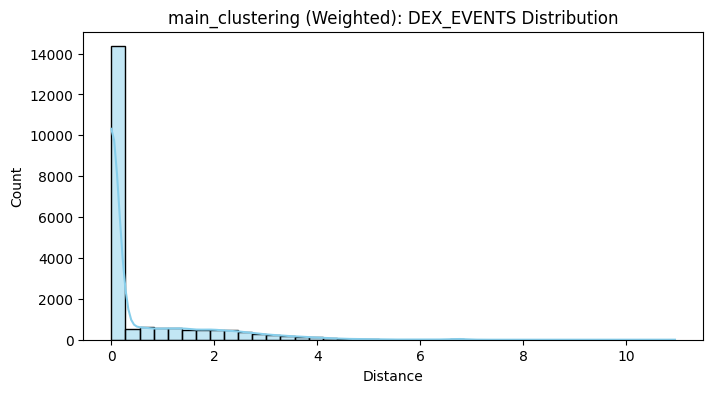

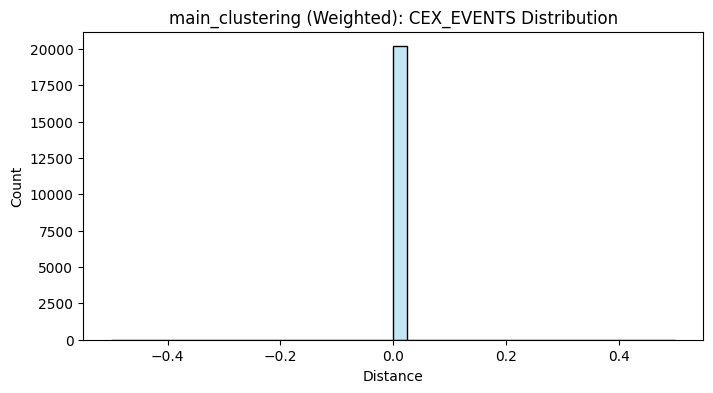

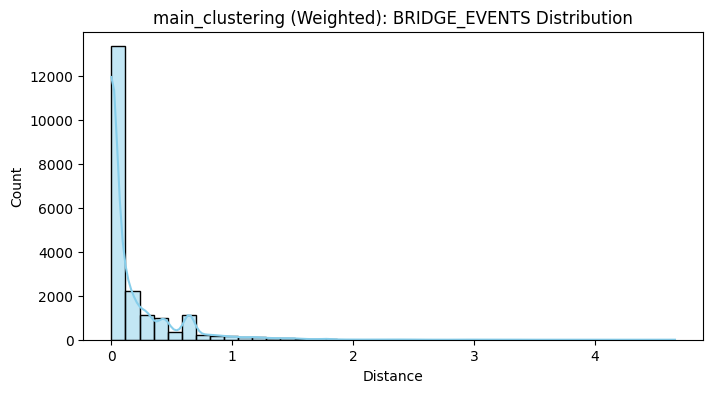

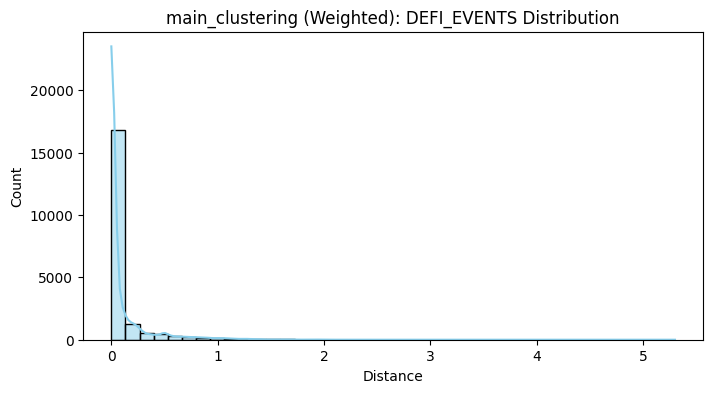

,mean,median,std,skewness,kurtosis
DEX_EVENTS,0.553757,0.0,1.084770,2.441288,7.452142
CEX_EVENTS,0.000000,0.0,0.000000,NaN,NaN
BRIDGE_EVENTS,0.173378,0.0,0.318595,3.388304,18.342801
DEFI_EVENTS,0.091483,0.0,0.242399,4.528153,32.363615


--- Weighted Distances: cluster_0_clustering ---


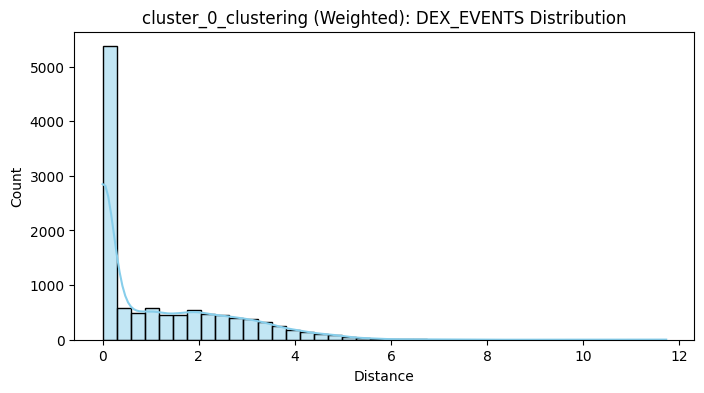

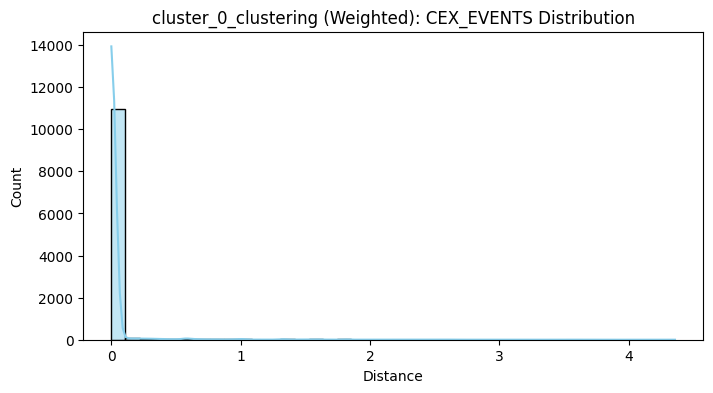

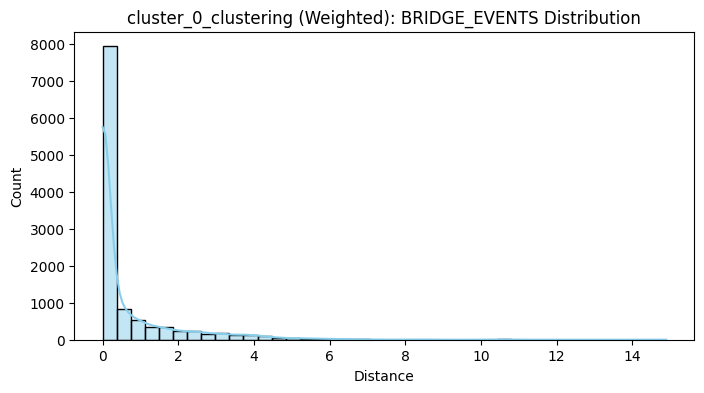

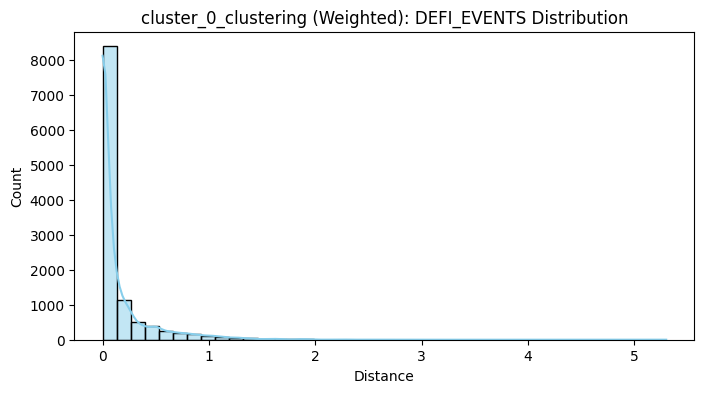

,mean,median,std,skewness,kurtosis
DEX_EVENTS,1.142573,0.436517,1.416711,1.214638,1.352638
CEX_EVENTS,0.031732,0.000000,0.221060,9.583923,109.693559
BRIDGE_EVENTS,0.615465,0.000000,1.255799,3.131876,13.834143
DEFI_EVENTS,0.143440,0.000000,0.288088,3.558069,21.130326


--- Weighted Distances: cluster_1_clustering ---


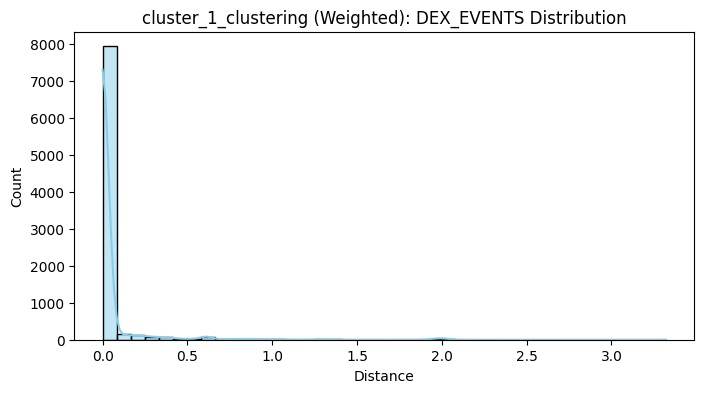

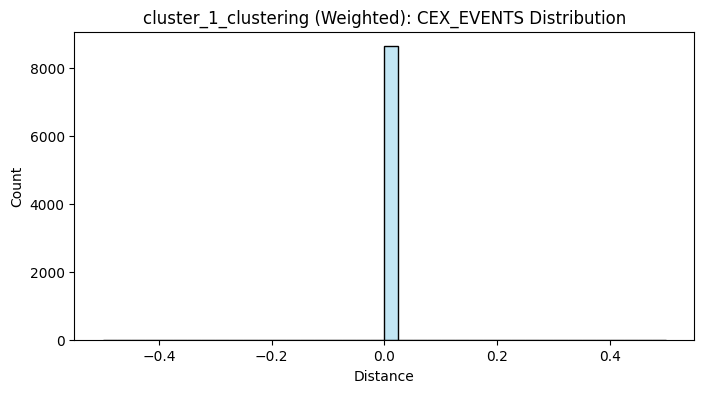

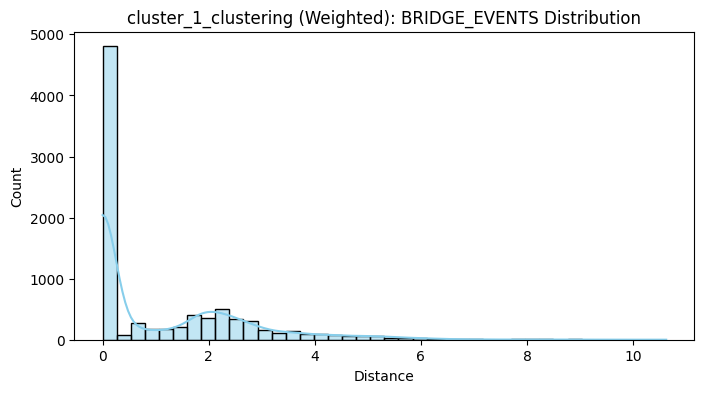

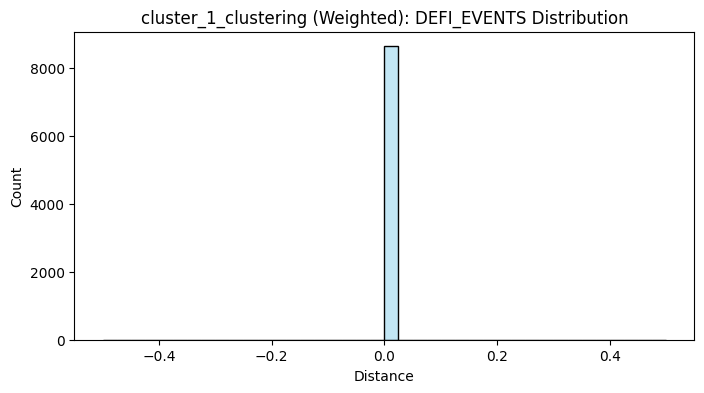

,mean,median,std,skewness,kurtosis
DEX_EVENTS,0.045736,0.0,0.219636,6.950386,55.784465
CEX_EVENTS,0.000000,0.0,0.000000,NaN,NaN
BRIDGE_EVENTS,1.107020,0.0,1.538304,1.461231,2.095408
DEFI_EVENTS,0.000000,0.0,0.000000,NaN,NaN


In [2]:
def plot_and_stats(df, title_prefix):
    stats = {}
    for col in df.columns:
        if not np.issubdtype(df[col].dtype, np.number):
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=40, color='skyblue')
        plt.title(f'{title_prefix}: {col} Distribution')
        plt.xlabel('Distance')
        plt.ylabel('Count')
        plt.show()
        # Compute statistics
        stats[col] = {
            'mean': np.mean(df[col]),
            'median': np.median(df[col]),
            'std': np.std(df[col]),
            'skewness': skew(df[col], nan_policy='omit'),
            'kurtosis': kurtosis(df[col], nan_policy='omit')
        }
    return pd.DataFrame(stats).T

# Visualize and summarize for each cluster and distance type
for cluster in clusters:
    if cluster in norm_dfs:
        print(f'--- Normalised Distances: {cluster} ---')
        display(plot_and_stats(norm_dfs[cluster], f'{cluster} (Normalised)'))
    if cluster in weight_dfs:
        print(f'--- Weighted Distances: {cluster} ---')
        display(plot_and_stats(weight_dfs[cluster], f'{cluster} (Weighted)'))


## Interpretation and Next Steps

- Review the distribution plots for each feature and cluster to assess the spread and shape of the distance scores.
- Use the summary statistics (mean, median, std, skewness, kurtosis) to compare features and clusters.
- Consider:
    - Are the distributions heavy-tailed or symmetric?
    - Do high distance scores correspond to wallets with outlier or high-activity behavior?
    - Are the weighted distances more interpretable or discriminative than the normalised ones?
- Use these insights to refine the distance metric or to select thresholds for identifying significant wallets in each interaction mode.
